In [1]:
import sys

import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from keras import datasets


sys.path.append("/home/hui/tutorials/learn_gm/Generative_Deep_Learning")

from notebooks.train import StepByStep

2024-09-29 22:22:27.661729: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-29 22:22:27.713978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 22:22:27.735050: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 22:22:27.739750: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-29 22:22:27.755595: I tensorflow/core/platform/cpu_feature_guar

## 1. MLP

In [16]:
class Cifar10Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


class Cifar10MLPModel(torch.nn.Module):
    def __init__(self, num_classes, fig_size=32):
        super().__init__()
        self.layer1 = torch.nn.Flatten()
        self.layer2 = torch.nn.Linear(fig_size**2 * 3, 200)
        self.layer3 = torch.nn.Linear(200, 150)
        self.layer4 = torch.nn.Linear(150, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = torch.nn.functional.relu(x)
        x = self.layer3(x)
        x = torch.nn.functional.relu(x)
        x = self.layer4(x)

        return x


In [4]:
NUM_CLASSES = 10
BATCH_SIZE = 32

(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

x_train = np.transpose(x_train, (0, 3, 1, 2))
x_test = np.transpose(x_test, (0, 3, 1, 2))

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = y_train.squeeze()
y_test = y_test.squeeze()


train_dataset = Cifar10Dataset(x_train, y_train)
test_dataset = Cifar10Dataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


model = Cifar10MLPModel(num_classes=NUM_CLASSES)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


In [6]:
EPOCH_NUM = 10
DEVICE = torch.device("cuda")
RANDOM_SEED = 0

setp_by_step = StepByStep(model, criterion, optimizer)
setp_by_step.set_seed(RANDOM_SEED)
setp_by_step.set_loaders(train_loader, test_loader)
setp_by_step.train(EPOCH_NUM, seed=RANDOM_SEED)


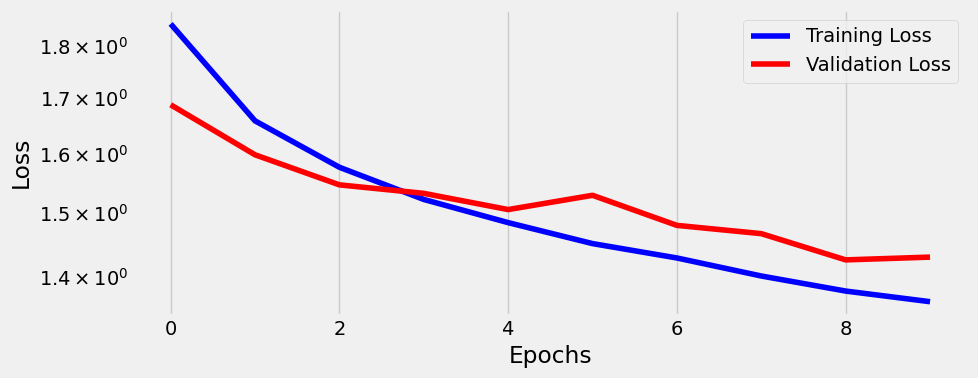

In [8]:
_ = setp_by_step.plot_losses()

In [14]:
y_test_pred = setp_by_step.predict(x_test)
test_acc = (y_test == y_test_pred.argmax(1)).mean()

y_train_pred = setp_by_step.predict(x_train)
train_acc = (y_train == y_train_pred.argmax(1)).mean()

print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")

Train accuracy: 0.52666
Test accuracy: 0.4913


## 2. CNN

In [24]:
class Cifar10CNNModel(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = torch.nn.BatchNorm2d(32)

        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)
        self.batch_norm2 = torch.nn.BatchNorm2d(32)

        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.batch_norm3 = torch.nn.BatchNorm2d(64)

        self.conv4 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.batch_norm4 = torch.nn.BatchNorm2d(64)

        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(4096, 128)
        self.batch_norm5 = torch.nn.BatchNorm1d(128)
        self.fc2 = torch.nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = torch.nn.functional.leaky_relu(x)

        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = torch.nn.functional.leaky_relu(x)

        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = torch.nn.functional.leaky_relu(x)

        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = torch.nn.functional.leaky_relu(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.batch_norm5(x)
        x = torch.nn.functional.leaky_relu(x)
        x = torch.nn.functional.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)

        return x

In [25]:
NUM_CLASSES = 10
BATCH_SIZE = 32

(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

x_train = np.transpose(x_train, (0, 3, 1, 2))
x_test = np.transpose(x_test, (0, 3, 1, 2))

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = y_train.squeeze()
y_test = y_test.squeeze()


train_dataset = Cifar10Dataset(x_train, y_train)
test_dataset = Cifar10Dataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


model = Cifar10CNNModel(num_classes=NUM_CLASSES)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


In [26]:
EPOCH_NUM = 10
DEVICE = torch.device("cuda")
RANDOM_SEED = 0

setp_by_step = StepByStep(model, criterion, optimizer)
setp_by_step.set_seed(RANDOM_SEED)
setp_by_step.set_loaders(train_loader, test_loader)
setp_by_step.train(EPOCH_NUM, seed=RANDOM_SEED)


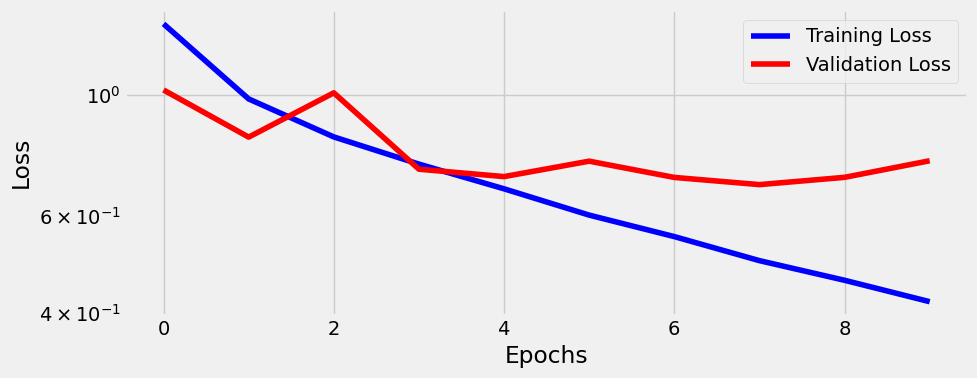

In [29]:
_ = setp_by_step.plot_losses()

In [31]:
def cal_acc(dataloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


test_acc = cal_acc(test_loader, model)
train_acc = cal_acc(train_loader, model)

print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")

Train accuracy: 0.91404
Test accuracy: 0.7503
